In [1]:
import sys
sys.path.append('../..')
from src.pomdp import *

import pandas as pd
import numpy as np
import cupy as cp


In [2]:
# For my computer: so it doesn't use shared GPU memory which is slower
# mempool = cp.get_default_memory_pool()
# mempool.set_limit(size=3.7*1024**3) # Allowing cupy 3.8 GB of GPU memory

## Model definition

In [3]:
olfactory_data = pd.read_csv('./Data/statistics_nose_3e6_35_153.dat', sep=',', header=None).values
olfactory_data = np.array(olfactory_data)

In [4]:
# Padding with zeros
olfactory_data_padded = np.pad(olfactory_data, 35)
olfactory_data = olfactory_data_padded

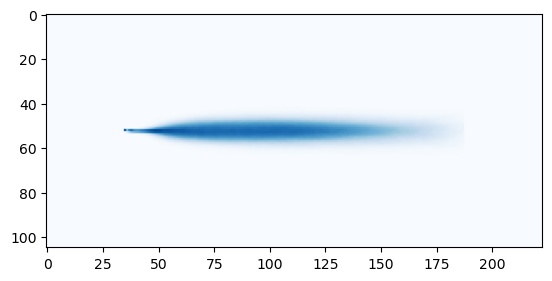

In [5]:
plt.imshow(olfactory_data, cmap='Blues')

In [6]:
# Model size
env_shape = olfactory_data.shape
state_count = env_shape[0] * env_shape[1]

print(f'Environment shape: {env_shape}')
print(f'State count: {state_count}')

Environment shape: (105, 223)
State count: 23415


In [7]:
# observation matrix
flattened_olfactory_data = olfactory_data.flatten()

observations = np.zeros((state_count, 4, 2)) # 4 actions, 2 observations
observations[:,:,0] = flattened_olfactory_data.reshape((flattened_olfactory_data.shape[0],1)).repeat(4, axis=1)
observations[:,:,1] = (1 - observations[:,:,0])

In [8]:
# State labels
state_grid = []
for i in range(env_shape[0]):
    i_states = []
    for j in range(env_shape[1]):
        i_states.append(f's_{i}_{j}')

    state_grid.append(i_states)

In [9]:
# Reachable states (for speedup)
row_w = env_shape[1]

reachable_states = np.zeros((state_count, 4, 1), dtype=int)
for s in range(state_count):
    reachable_states[s,0,0] = s - row_w if s - row_w >= 0 else s # North
    reachable_states[s,1,0] = s + 1 if (s + 1) % row_w > 0 else s # East
    reachable_states[s,2,0] = s + row_w if s + row_w < state_count else s # South
    reachable_states[s,3,0] = s - 1 if (s - 1) % row_w < (row_w - 1) else s # West

reachable_states = np.array(reachable_states)

In [10]:
# Definition of goal state
goal = ((17 + 35)*env_shape[1])+35

In [11]:
# Reward function
def reward_func(s,a,sn,o):
    return np.where(sn == goal, 1.0, 0.0)

In [12]:
model = Model(
    states=state_grid,
    actions=['N','E','S','W'],
    observations=['something', 'nothing'],
    reachable_states=reachable_states,
    rewards=reward_func,
    observation_table=observations,
    end_states=[goal]
)

[10/17/2023, 17:06:24] Instantiation of MDP Model:
[10/17/2023, 17:06:24] - 23415 states
[10/17/2023, 17:06:24] - 4 actions
[10/17/2023, 17:06:24] - At most 1 reachable states per state-action pair
[10/17/2023, 17:06:24] - Starting generation of transitions table
[Warning] No transition matrix or function provided but reachable states are, so probability to reach any reachable states will "1 / reachable state count" so here: 1.000.
[10/17/2023, 17:06:24]     > Done in 0.000s
[10/17/2023, 17:06:24] - Generation of state grid
[10/17/2023, 17:06:24] - Generating start probabilities table
[10/17/2023, 17:06:24] - Starting computation of reachable state probabilities from transition data
[10/17/2023, 17:06:24]     > Done in 0.001s
[10/17/2023, 17:06:24] POMDP particular parameters:
[10/17/2023, 17:06:24] - 2 observations
[10/17/2023, 17:06:24] - Starting of transitional observations for reachable states table
[10/17/2023, 17:06:24]     > Done in 0.007s
[10/17/2023, 17:06:24] - Starting gene

## VI Solve

In [13]:
from src.mdp import VI_Solver

In [14]:
solver = VI_Solver(eps=1e-3)

In [15]:
solution, history = solver.solve(model, use_gpu=True)
print(history.summary)

[10/17/2023, 17:06:24] Sending Model to GPU...
[10/17/2023, 17:06:25]     > Done in 0.671s


  0%|          | 0/10000 [00:00<?, ?it/s]

Summary of Value Iteration run
  - Model: 23415-state, 4-action
  - Converged in 231 iterations and 0.7147 seconds
  - Took on average 0.0031s per iteration


[Warning] Value function on GPU, converting to numpy before plotting...
[Warning] 'as_grid' parameter set to False but state count is >3 so it will be plotted as a grid


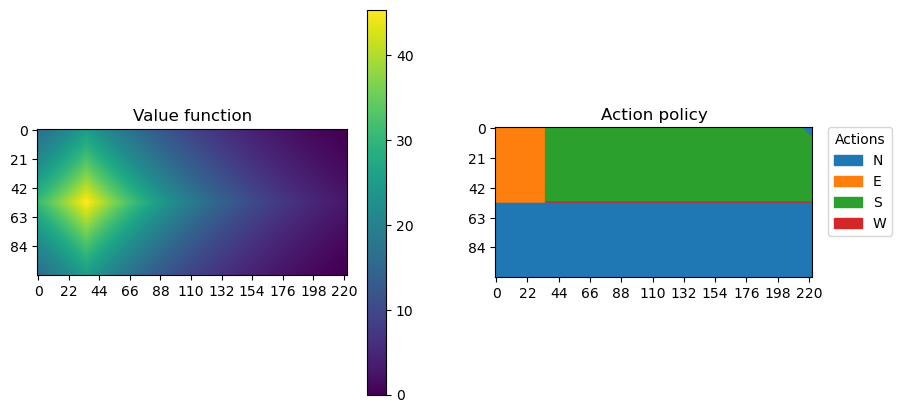

In [16]:
solution.plot()

## FSVI

In [17]:
fsvi_solver = FSVI_Solver(0.99, eps=1e-6)

In [18]:
fsvi_solution, hist = fsvi_solver.solve(model=model,
                                        expansions=300,
                                        horizon=300,
                                        mdp_policy=solution,
                                        belief_memory_depth=10,
                                        # prune_level=2, # Useless because of belief domination
                                        # prune_interval=25,
                                        # history_tracking_level=2,
                                        use_gpu=True)
print(hist.summary)

Expansions:   0%|          | 0/300 [00:00<?, ?it/s]

Summary of Value Iteration run
  - Model: 23415 state, 4 action, 2 observations
  - Converged or stopped after 300 expansion steps and 300 backup steps.
  - Converged in 220.4048s

  - Expand function took on average 0.0935s and yielded on average 106.86 beliefs per iteration.
  - Backup function took on average 0.6412s and yielded on average value functions of size 5134.00 per iteration.
  - Pruning function took on average 0.0000s and yielded on average prunings of 0.00 alpha vectors per iteration.


[Warning] Value function on GPU, converting to numpy before plotting...
[Warning] 'as_grid' parameter set to False but state count is >3 so it will be plotted as a grid


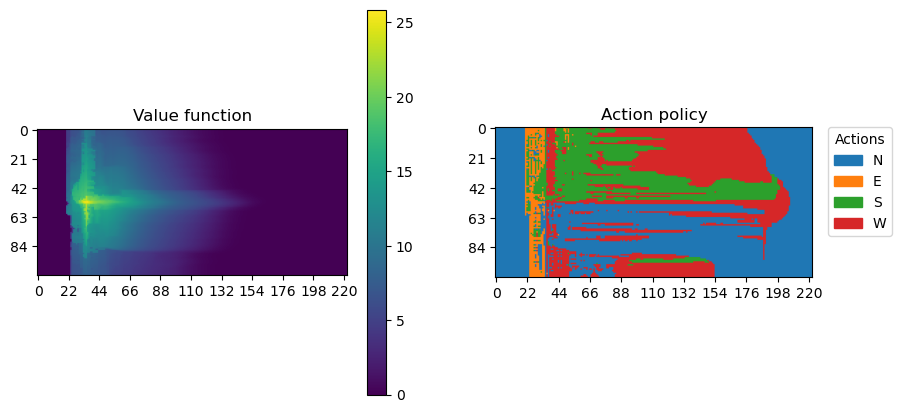

In [19]:
fsvi_solution.plot()

In [21]:
fsvi_solution.prune(level=2)

In [23]:
len(fsvi_solution)

10856

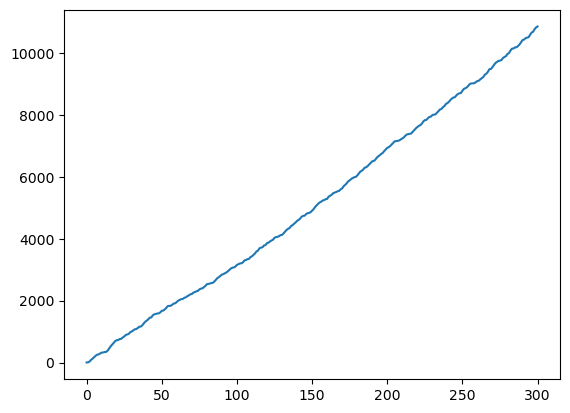

In [20]:
plt.plot(np.arange(len(hist.alpha_vector_counts)), hist.alpha_vector_counts)

In [20]:
len(fsvi_solution)

3314